# GAI Homework 4

## 1. Setup

In [10]:
import numpy as np
import torch  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import skimage
import skimage.transform

dtype = torch.cuda.FloatTensor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## U-Net Model

In [35]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class Unet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(Unet, self).__init__()

        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64,out_ch, 1)

    def forward(self,x):
        c1=self.conv1(x)
        p1=self.pool1(c1)
        c2=self.conv2(p1)
        p2=self.pool2(c2)
        c3=self.conv3(p2)
        p3=self.pool3(c3)
        c4=self.conv4(p3)
        p4=self.pool4(c4)
        c5=self.conv5(p4)
        up_6= self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6=self.conv6(merge6)
        up_7=self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7=self.conv7(merge7)
        up_8=self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8=self.conv8(merge8)
        up_9=self.up9(c8)
        merge9=torch.cat([up_9,c1],dim=1)
        c9=self.conv9(merge9)
        c10=self.conv10(c9)
        #out = nn.Sigmoid()(c10)
        return c10

## Gen Training Data like DDPM do in foward process

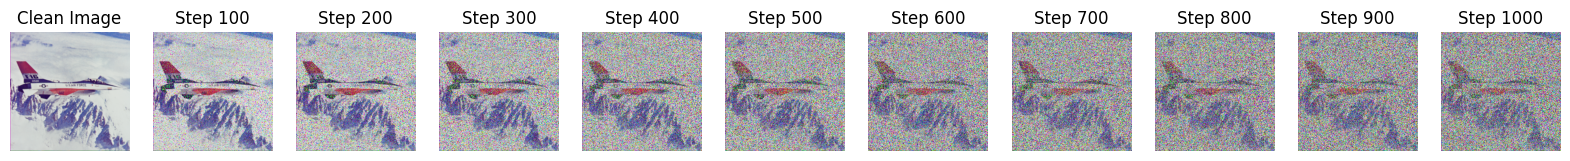

[36.983069451128216, 20.1900217378231, 17.390776755035088, 15.835727801843333, 14.777722594265105, 14.034888572335216, 13.467167310848176, 13.061809078148602, 12.726703574972353, 12.493578373999574, 12.321602532834511]


In [60]:
def show_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for idx, image in enumerate(images):
        axes[idx].imshow(image)
        axes[idx].set_title(titles[idx])
        axes[idx].axis('off')
    plt.show()
    
psnr_value_array = []

def ddpm_forward_pass(clean_image, num_steps=1000, beta_start=0.0001, beta_end=0.00002):
    betas = np.linspace(beta_start, beta_end, num_steps)
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas)

    clean_image = clean_image[None, :, :, :]
    x_t = clean_image
    intermediate_images = []

    for t in range(num_steps):
        noise = np.random.normal(0, 1, clean_image.shape)
        alpha_t = alphas_cumprod[t]
        x_t = np.sqrt(alpha_t) * clean_image + np.sqrt(1 - alpha_t) * noise
        
        if t == 1:
            psnr_value_array.append(skimage.metrics.peak_signal_noise_ratio(clean_image[0],x_t[0]))

        if (t + 1) % 100 == 0:
            intermediate_images.append((x_t[0] * 255).astype(np.uint8))
            psnr_value_array.append(skimage.metrics.peak_signal_noise_ratio(clean_image[0],x_t[0]))
    
    return intermediate_images


clean_image = skimage.io.imread('F16_GT.png')
clean_image = skimage.transform.resize(clean_image,(256,256))

intermediate_images = ddpm_forward_pass(clean_image)
intermediate_images.insert(0, clean_image)

titles = ["Clean Image"] + [f"Step {i*100}" for i in range(1, 11)]
show_images(intermediate_images, titles)
print(psnr_value_array)

## Training

In [74]:
def train_model(model,mse, optimizer,target_image,noise_images, num_epochs=500):
    step = 0
    
    for i in range(1,len(noise_images)+1):
        
        now = noise_images[len(noise_images)-i] / 255
        now = torch.from_numpy(now).to(torch.float)
        print(now.shape)
        
        for epoch in range(num_epochs):
            model.train()
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            epoch_loss = 0
            step += 1
            inputs = now.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            
            print(outputs.shape)
            
            loss = mse(target_image,outputs)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("epoch %d loss:%0.3f" % (epoch, epoch_loss/step))
            
            # PSNR early stopping
            
        # torch.save(model.state_dict(), 'weights_%d.pth' % epoch )
        print(f'Pass to stage {i}')
    
    return model

def train(image,intermediate_images):
    image = skimage.transform.resize(clean_image,(256,256))
    #intermediate_images = ddpm_forward_pass(clean_image)
    model = Unet(3, 3).to(device)
    mse = nn.MSELoss().type(dtype).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    train_model(model,mse, optimizer, image,intermediate_images)
    
image = skimage.io.imread('F16_GT.png')
train(image,intermediate_images=intermediate_images)

torch.Size([256, 256, 3])
Epoch 0/499
----------


RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 256, 256, 3] to have 3 channels, but got 256 channels instead